https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1

In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import torchvision

import matplotlib.pyplot as plt

%matplotlib inline

fig_dir = './figs'

In [3]:
## Dataset parameters
input_shape = 28*28

## Model parameters
p_dropout = 0.1
hidden_layer_size = 64

## Optimizer parameters
train_batch_size = 1000
test_batch_size = 1000
learning_rate = 10
momentum = 0.5

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, 
    shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4
)    

Extracting /home/nahuel/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /home/nahuel/torch_datasets/MNIST/raw


Extracting /home/nahuel/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /home/nahuel/torch_datasets/MNIST/raw


Extracting /home/nahuel/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/nahuel/torch_datasets/MNIST/raw


Extracting /home/nahuel/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/nahuel/torch_datasets/MNIST/raw
Processing...
Done!


/home/nahuel/anaconda3/envs/redes/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729002806/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


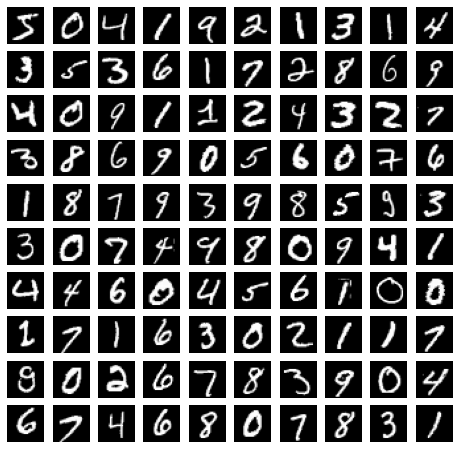

In [12]:
Nshowx = 10
Nshowy = 10
plt.figure(figsize=(8,8))
for i in range(1,Nshowx*Nshowy+1): 
    plt.subplot(Nshowx,Nshowy,i)
    plt.imshow(train_dataset.data[i-1], cmap='gray')
    plt.axis("off")
plt.savefig(os.path.join(fig_dir, 'ejemplos.pdf'), dpi=300)
plt.show()

In [5]:
dir_name = '/content/gdrive/My Drive/Colab Notebooks/pytorch/Autoencoder_MNIST_files'
base_model_name = 'hidden{:04}_dropout{:.3f}_batch{:05}_lr{:.6f}_momentum{:.6f}'.format(
    hidden_layer_size, p_dropout, train_batch_size, learning_rate, momentum
)
model_name = base_model_name + '.pt'
loss_name  = base_model_name + '.txt'

print(model_name)
model_path = os.path.join(dir_name, 'models', model_name)
loss_path = os.path.join(dir_name, 'loss', loss_name)




hidden0064_dropout0.100_batch01000_lr10.000000_momentum0.500000.pt


In [6]:
class Flatten(nn.Module):
    def forward(self, inpt):
        return inpt.view(inpt.size(0), -1)

class Squeeze(nn.Module):
    def forward(self, inpt):
        return inpt.view(inpt.size(0), 1, 28, 28)

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.hidden_layer = nn.Linear(
            in_features=kwargs['input_shape'], 
            out_features=kwargs['hidden_layer_size']
        )
        self.output_layer = nn.Linear(
            in_features=kwargs['hidden_layer_size'],
            out_features=kwargs['input_shape']
        )        
        self.flatten = Flatten()
        self.squeeze = Squeeze()
        self.dropout = nn.Dropout(kwargs['p_dropout'])

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden_layer(x)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.output_layer(x)
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.squeeze(x)
        return x

In [7]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(
    input_shape=input_shape,
    hidden_layer_size=hidden_layer_size,
    p_dropout=p_dropout
).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# mean-squared error loss
criterion = nn.MSELoss()

Device: cpu


In [ ]:
model.load_state_dict(torch.load(path))
model.eval()

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

RuntimeError: ignored

In [7]:
train_loss_values = []
test_loss_values  = []

In [8]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:

        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    avg_train_loss = loss / len(train_loader)

    train_loss_values.append(avg_train_loss)

    with torch.no_grad():
        loss = 0
        for batch_features, _ in test_loader:

            # load it to the active device
            batch_features = batch_features.to(device)
            
            # compute reconstructions
            outputs = model(batch_features)
            
            # compute testing reconstruction loss
            test_loss = criterion(outputs, batch_features)
                        
            # add the mini-batch testing loss to epoch loss
            loss += test_loss.item()
    
    # compute the epoch testing loss
    avg_test_loss = loss / len(test_loader)

    test_loss_values.append(avg_test_loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, train loss = {:.6f}, test loss = {:.6f}, ".format(
        epoch + 1, epochs, avg_train_loss, avg_test_loss)
    )

















epoch : 1/20, train loss = 0.068401, test loss = 0.050261, 
epoch : 2/20, train loss = 0.045091, test loss = 0.040831, 
epoch : 3/20, train loss = 0.038770, test loss = 0.036850, 
epoch : 4/20, train loss = 0.035843, test loss = 0.034734, 
epoch : 5/20, train loss = 0.033908, test loss = 0.033011, 
epoch : 6/20, train loss = 0.032641, test loss = 0.032062, 
epoch : 7/20, train loss = 0.031703, test loss = 0.031330, 
epoch : 8/20, train loss = 0.031048, test loss = 0.030742, 
epoch : 9/20, train loss = 0.030571, test loss = 0.030169, 
epoch : 10/20, train loss = 0.030166, test loss = 0.029943, 
epoch : 11/20, train loss = 0.029831, test loss = 0.029598, 
epoch : 12/20, train loss = 0.029580, test loss = 0.029400, 
epoch : 13/20, train loss = 0.029401, test loss = 0.029180, 
epoch : 14/20, train loss = 0.029091, test loss = 0.029074, 
epoch : 15/20, train loss = 0.028896, test loss = 0.028729, 
epoch : 16/20, train loss = 0.028741, test loss = 0.028679, 
epoch : 17/20, tr

In [9]:
torch.save(model.state_dict(), model_path)
np.savetxt(loss_path, np.array([train_loss_values, test_loss_values]).T)

FileNotFoundError: ignored

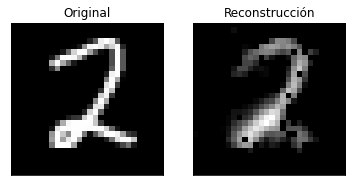

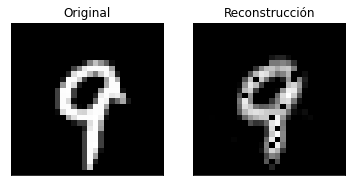

In [11]:
def compare(dataset, n=None):

  if not n:
    n = np.random.randint(dataset.data.size(0))
  inpt = dataset[n][0]

  original = inpt.detach().numpy().squeeze()
  autoencoded = model(inpt).detach().numpy().squeeze()

  titles = ['Original', 'Reconstrucción']

  fig, axes = plt.subplots(ncols=2)

  for i, img in enumerate([original, autoencoded]):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i])
    ax.imshow(img, cmap='gray')

compare(train_dataset)
compare(test_dataset)


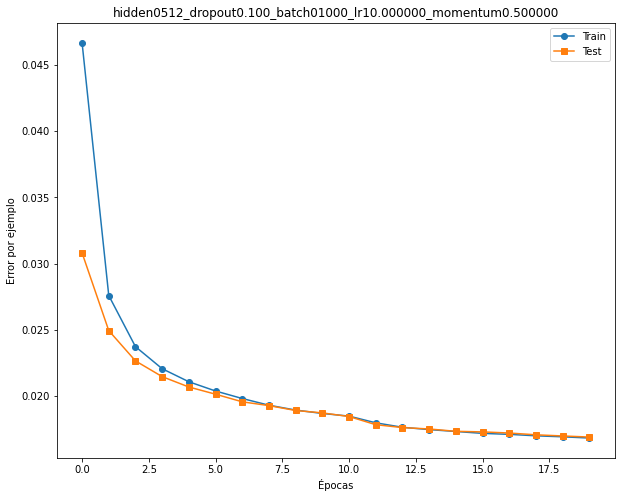

In [ ]:
epochs = np.arange(len(train_loss_values))

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_title(base_model_name)

ax.set_ylabel('Error por ejemplo')
ax.set_xlabel('Épocas')

ax.plot(epochs, np.array(train_loss_values), 'o-', label='Train')
ax.plot(epochs, np.array(test_loss_values), 's-', label='Test')

ax.legend()

plt.savefig(os.path.join(dir_name, 'figs', base_model_name + '.png'))
plt.show()

In [ ]:
train_loss_dict = {}
test_loss_dict = {}

hidden_values = [64, 128, 256, 512]

for hidden in hidden_values:

    inpt_file_name = 'hidden{:04}_dropout{:.3f}_batch{:05}_lr{:.6f}_momentum{:.6f}'.format(
        hidden, p_dropout, train_batch_size, learning_rate, momentum
    )
    train_loss, test_loss = np.loadtxt(
        os.path.join(dir_name, 'loss', inpt_file_name + '.txt')  
    ).T

    train_loss_dict[hidden] = train_loss
    test_loss_dict[hidden] = test_loss

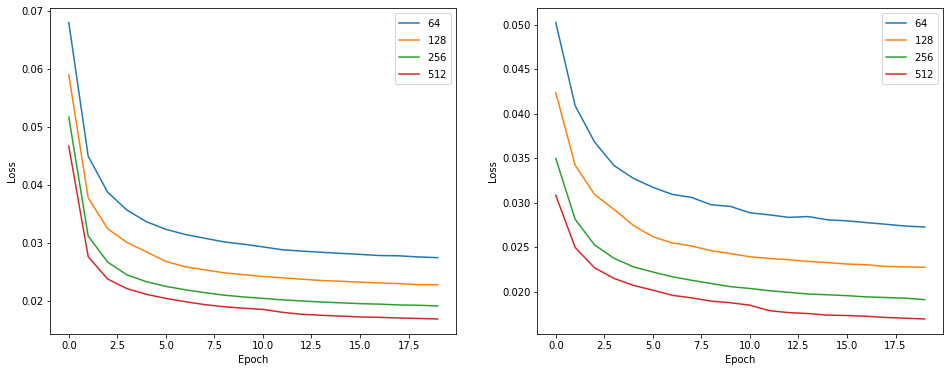

In [ ]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for hidden in hidden_values:
    train_loss, test_loss = train_loss_dict[hidden], test_loss_dict[hidden]
    for i, loss_values in enumerate([train_loss, test_loss]):
        ax = axes[i]
        epochs = np.arange(train_loss.shape[0])
        ax.plot(epochs, loss_values, label=r'${{{}}}$'.format(hidden))

for ax in axes:
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend()

plt.show()